In [1]:
# Import necessary modules
import numpy as np
import math
import matplotlib as mpl
import matplotlib.animation as animation
import matplotlib.pyplot as plt
import os
import pandas as pd
import sys
import pyomo.environ as pyo


from datetime import datetime, timedelta
from matplotlib import rc

# Plotting settings
'''
plt.rcParams.update({
    'text.usetex': True,
    'font.family': 'Computer Modern Roman',
})
'''

"\nplt.rcParams.update({\n    'text.usetex': True,\n    'font.family': 'Computer Modern Roman',\n})\n"

In [2]:
do_not_edit_directory = 'do_not_edit'
sys.path.insert(1, do_not_edit_directory)

In [3]:
# Load global constants
from helper_functions import *
from constants import *
globals().update(locals())

In [4]:
# Simulation Settings
total_simulation_days = get_number_day(end_date) - get_number_day(start_date) # total simulation time in days,         [days]
total_time_steps      = total_simulation_days * num_time_steps_per_day        # total number of simulation time steps, [unitless]

# System Disturbances - Hourly Temperature and Incident Solar Radiation
#disturbance_data = pd.read_csv(f'{do_not_edit_directory}/hourly_temp_rad_corn.csv')
#hourly_temperatures = disturbance_data['Hourly Temperatures'].to_numpy()
#hourly_radiation    = disturbance_data['Hourly Incident Radiation'].to_numpy()

In [5]:
# System Inputs - NON MPC INPUTS !! For example only
input_data = pd.read_csv(f'{do_not_edit_directory}/hourly_water_fertilizer_corn.csv')
hourly_irrigation = input_data['Hourly Water Consumption'].to_numpy()
hourly_fertilizer = input_data['Hourly Fertilizer Consumption'].to_numpy()

In [6]:
# Import dynamics functions

# NONLINEAR DYNAMCIS
from nonlinear_plant_dynamics import *

# LINEARIZED DYNAMICS
#from linear_plant_dynamics import *

In [7]:
# Set initial condition
initial_height         = 0.01 
initial_leaf_area      = 1e-5 
initial_canopy_biomass = 0.01 
initial_fruit_biomass  = 0.01 
initial_dAdt           = 0.01 

x0 = np.array([initial_height, initial_leaf_area, initial_canopy_biomass, initial_fruit_biomass, initial_dAdt])

In [8]:
# All distrubances
disturbances = np.loadtxt('exact_disturbances.csv', delimiter=',')
N= 10
d = disturbances[:, 0:N+1]

In [23]:
# CFTOC
#def solve_cftoc(P, Q, R, N, x0, xL, xU, uL, uU):
def solve_cftoc(N, x0, d):

    model = pyo.ConcreteModel()

    # Variables
    model.kidx = pyo.Set(initialize=range(0, N+1)) # length of finite optimization problem
    model.xidx = pyo.Set(initialize=range(0, 4))
    model.uidx = pyo.Set(initialize=range(0, 5))
    model.didx = pyo.Set(initialize=range(0, 7))

    model.x = pyo.Var(model.xidx, model.kidx, bounds=(1e-6, 100))
    model.u = pyo.Var(model.uidx, model.kidx, bounds=(1e-6, 100))
    model.d = pyo.Param(model.didx, model.kidx, initialize=lambda model, i, k: disturbances[i, k])

    # Objective function
    #model.cost = sum((model.x[i, k])**2 for i in model.xidx for k in model.kidx)
    R = np.eye(5)
    c = np.ones(4) * 100
    
    def cost_function(model):
      cost = 0
      #Stage cost (u'Ru)
      for k in range(N):  # up to N-1
        cost += sum(R[i, j] * model.u[i, k] * model.u[j, k] for i in model.uidx for j in model.uidx)
      # Terminal cost (c'x)
      cost -= sum(c[i] * model.x[i, N] for i in model.xidx)
      return cost
    
    model.cost = pyo.Objective(rule=cost_function, sense=pyo.minimize)
    #model.obj = pyo.Objective(expr=model.cost, sense=pyo.minimize)

    # Initial Condition
    model.initial_condition = pyo.Constraint(model.xidx, rule = lambda model, i:model.x[i,0] == x0[i])

    def sigmoid(x, eps=1e-9):
      return 1 / (1 + pyo.exp(-x/eps))

    # Plant Height Dynamics
    def plant_height_dynamics(model, i, k):
      if k < N:
        # Logistic growth term
        logistic_growth_term = growth_rate_height * model.x[0, k] * (1 - model.x[0, k] / carrying_capacity_height)

        #Gaussian irrigation term
        gaussian_irrigation_term = sigmoid(model.u[0, k]) * gains_height_from_water * growth_rate_height_water_specific * model.u[0, k] * pyo.exp(-((model.u[1, k] - scaling_factor_peak_height_growth_water_specific * model.u[0, k]) / (scaling_factor_peak_growth_time_height_water_specific * model.u[0, k]))**2)
          #gaussian_irrigation_term = (
           #   gains_height_from_water
            #  * growth_rate_height_water_specific
             # * model.u[0, k]
              #* pyo.exp(-((model.u[1, k] - scaling_factor_peak_height_growth_water_specific * model.u[0, k])
               #           / (scaling_factor_peak_growth_time_height_water_specific * model.u[0, k]))**2)
          #)

        # Gaussian fertilizer term
        #gaussian_fertilizer_term = (
         #   gains_height_from_fertilizer
          #  * growth_rate_height_fertilizer_specific
           # * model.u[3, k]
            #* pyo.exp(-((model.u[4, k] - scaling_factor_peak_height_growth_fertilizer_specific * model.u[3, k])
                    #    / (scaling_factor_peak_growth_time_height_fertilizer_specific * model.u[3, k]))**2)
        #)

        # Decay term
        decay_term = -1 * decay_rate_height * model.x[0, k]

        # Dynamics equation
        dhdt = logistic_growth_term + gaussian_irrigation_term  #+ gaussian_fertilizer_term   #+ height_decay_effect

        return model.x[0, k + 1] == model.x[0, k] + dhdt * time_step_size
      else:
        return pyo.Constraint.Skip
    
    model.plant_height_dynamics = pyo.Constraint(model.xidx, model.kidx, rule=plant_height_dynamics)
    
    #Leaf_area dynamics
    #def leaf_area(model, i, k):
      #if k<N:
        #gaussian_temperature_term =  gains_leaf_area_from_temp * growth_rate_leaf_area_temp_specific * model.d[3,k]\
                                  #* pyo.exp(-((model.d[4,k] - scaling_factor_peak_leaf_area_growth_temp_specific * model.d[3,k])/\
                                   #        (scaling_factor_peak_growth_time_leaf_area_temp_specific * model.d[3,k]))**2)
        
        
        #gaussian_irrigation_term = gains_leaf_area_from_water * growth_rate_leaf_area_water_specific * model.u[0, k]\
         #                       * pyo.exp(-((model.u[1, k] - scaling_factor_peak_leaf_area_growth_water_specific * model.u[0, k])/\
          #                                (scaling_factor_peak_growth_time_leaf_area_water_specific * model.u[0, k]))**2)
        
        #gaussian_fertilizer_term = gains_leaf_area_from_fertilizer * growth_rate_leaf_area_fertilizer_specific * model.u[3, k]\
         #                       * pyo.exp(-((model.u[4, k] - scaling_factor_peak_leaf_area_growth_fertilizer_specific * model.u[3, k])/\
          #                                  (scaling_factor_peak_growth_time_leaf_area_fertilizer_specific * model.u[3, k]))**2)
        
        #dAdt =  1 #gaussian_temperature_term + gaussian_irrigation_term # + gaussian_fertilizer_term

        
       # return model.x[1, k + 1] == model.x[1, k] + dAdt * time_step_size 
      #else:
     #   return pyo.Constraint.Skip
      
    #model.leaf_area = pyo.Constraint(model.xidx, model.kidx, rule=leaf_area)
    model.leaf_area = x0[1]

    #canopy_biomass dynamics
    #def canopy_biomass(model, i, k):
      #if k<N:
        #dcdt = efficiency_coefficient_photosynthesis * model.d[0, k] * model.x[1, k]\
       #            * growth_rate_canopy_biomass * model.x[2, k]\
       #           * (1 - model.x[2, k]/carrying_capacity_canopy_biomass)
        #return model.x[2, k + 1] == model.x[2, k] + dcdt * time_step_size
      #else:
       # return pyo.Constraint.Skip
      
    #model.canopy_biomass = pyo.Constraint(model.xidx, model.kidx, rule=canopy_biomass)
    model.canopy_biomass = x0[2]

    #fruit biomass
    def fruit_biomass(model, i, k):
      if k<N:
        dPdt = growth_rate_fruit_biomass * model.d[6, k]\
                    * model.x[2, k]/carrying_capacity_canopy_biomass\
                    * model.x[3, k] * (1 - model.x[3, k]/carrying_capacity_fruit_biomass)
        
        return model.x[3, k + 1] == model.x[3, k] + dPdt * time_step_size
      else:
        return pyo.Constraint.Skip
      
    model.fruit_biomass = pyo.Constraint(model.xidx, model.kidx, rule=fruit_biomass)
          

    # Solve
    #solver = pyo.SolverFactory('ipopt', executable='C:\\Program Files\\Ipopt-3.14.16-win64-msvs2019-md\\Ipopt-3.14.16-win64-msvs2019-md\\bin\\ipopt.exe')
    solver = pyo.SolverFactory('ipopt')
    results = solver.solve(model, tee=True)
    feas = results.solver.termination_condition == pyo.TerminationCondition.optimal

  # Retrieve the results
    if feas:
      xOpt = np.array([[model.x[i, k].value for k in model.kidx] for i in model.xidx])
      uOpt = np.array([[model.u[i, k].value for k in model.kidx] for i in model.uidx])
      JOpt = pyo.value(model.cost)
    else:
      raise ValueError("Optimization failed to find an optimal solution.")

    return [feas, xOpt, uOpt, JOpt]

    print("Solver status:", results.solver.status)
    print("Termination condition:", results.solver.termination_condition)

In [24]:
[feas, xOpt, uOpt, JOpt] = solve_cftoc(24, x0, d)
print('JOpt=', JOpt)
print('xOpt=', xOpt)
print('uOpt=', uOpt)
print('Feas=', feas)

Ipopt 3.14.16: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.16, running with linear solver MUMPS 5.6.2.

Number of nonzeros in equality constraint Jacobian...:      676
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      216

Total number of variables............................:      197
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      197
                     variables with only upper bounds:        0
Total number of equality constraints.................:      196
Total number

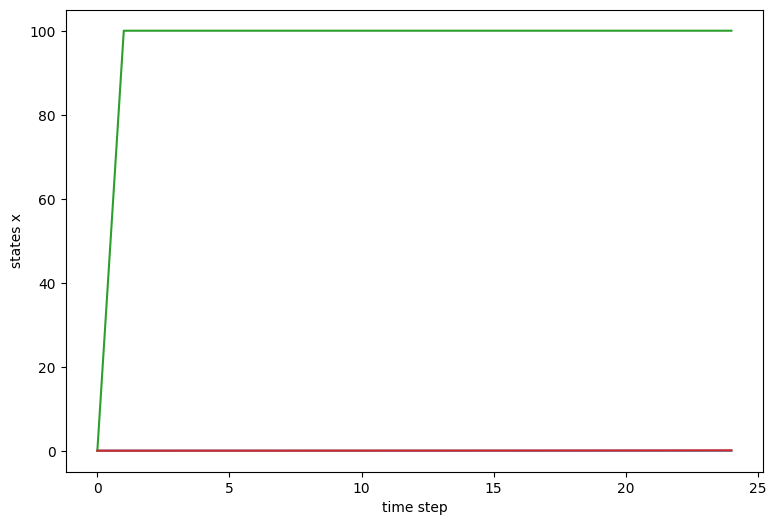

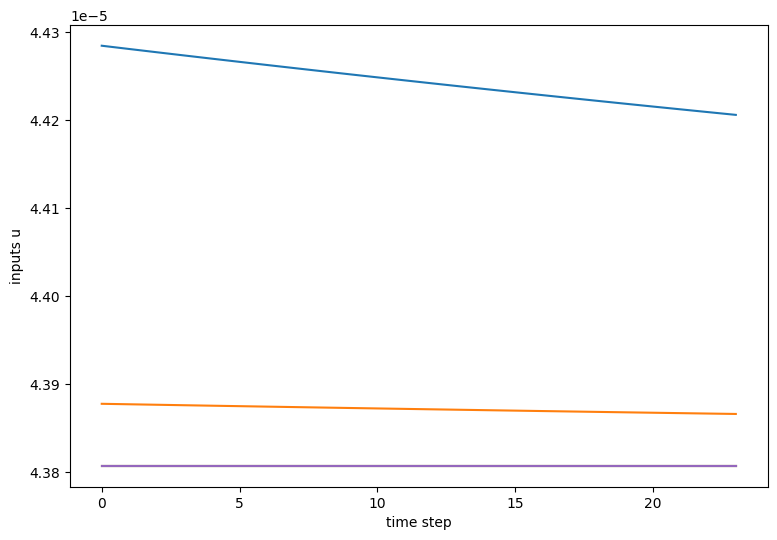

In [25]:
fig = plt.figure(figsize=(9, 6))
plt.plot(xOpt.T)
plt.ylabel('states x')
plt.xlabel('time step')
fig = plt.figure(figsize=(9, 6))
plt.plot(uOpt.T)
plt.ylabel('inputs u')
plt.xlabel('time step')
plt.show()

In [ ]:
# Initialize storage arrays for effective, cumulative, and sensitivity values
effective_temperatures = np.zeros(total_simulation_days)
effective_irrigation = np.zeros(total_simulation_days)
effective_fertilizer = np.zeros(total_simulation_days)

cumulative_temperatures = np.zeros(total_simulation_days)
cumulative_irrigation = np.zeros(total_simulation_days)
cumulative_fertilizer = np.zeros(total_simulation_days)

leaf_sensitivity_temp = np.zeros(total_simulation_days)
leaf_sensitivity_water = np.zeros(total_simulation_days)
fruit_sensitivity_temp = np.zeros(total_simulation_days)

In [ ]:
#----- MAIN SIMULATION -----#

# Set triggers
height_decay_triggered       = False
leaf_decay_triggered         = False
fruit_canopy_decay_triggered = False

# Initialize cumulative values
cum_temperature = 0
cum_irrigation  = 0
cum_fertilizer  = 0

# Begin simulation
days_after_sowing = 0
todays_date = start_date
for day in range(1, total_simulation_days):

    # Print out the day
    #print(f'Day {day+1} of {total_simulation_days}')

    # Update days after sowing and today's date
    days_after_sowing += 1
    todays_date += timedelta(days=1)

    # Update the effective values
    eff_temperature, eff_irrigation, eff_fertilizer = update_effective_model(day, hourly_temperatures, hourly_irrigation, hourly_fertilizer)

    # Update the average values
    average_temperature, average_irrigation = update_average_values(day, hourly_temperatures, hourly_irrigation)

    # Update the sensitivity values
    leaf_sens_temp, leaf_sens_water, fruit_sens_temp = update_sensitivity_values(average_temperature, average_irrigation)

    # Update the cumulative values
    cum_temperature += eff_temperature
    cum_irrigation  += eff_irrigation
    cum_fertilizer  += eff_fertilizer

    # Store the effective, cumulative, and sensitivity values
    effective_temperatures[day] = eff_temperature
    effective_irrigation[day] = eff_irrigation
    effective_fertilizer[day] = eff_fertilizer

    cumulative_temperatures[day] = cum_temperature
    cumulative_irrigation[day] = cum_irrigation
    cumulative_fertilizer[day] = cum_fertilizer

    leaf_sensitivity_temp[day] = leaf_sens_temp
    leaf_sensitivity_water[day] = leaf_sens_water
    fruit_sensitivity_temp[day] = fruit_sens_temp

    # Loop over time steps (for updates that happen periodically throughout a single day)
    for time_step in range(num_time_steps_per_day):

        # Index for time-dependent variables
        t = day * num_time_steps_per_day + time_step
        if t == total_time_steps-1:
            break # cannot fill the t+1 position if this condition is true, so break the loop

        # Update today's date to the hour
        todays_date += timedelta(hours=time_step_size)

        # Initialize an instance of the SolarPosition class based on latest time
        solar_zenith_angle = get_solar_zenith_angle(todays_date)
        initial_rad        = hourly_radiation[day]

        # Plant height update
        height[t+1] = update_plant_height(height[t], eff_irrigation, eff_fertilizer, cum_irrigation, cum_fertilizer)

        # Leaf area update
        dAdt[t+1], leaf_area[t+1] = update_leaf_area(height[t],
                                                leaf_area[t],
                                                eff_temperature,
                                                eff_irrigation,
                                                eff_fertilizer,
                                                cum_temperature,
                                                cum_irrigation,
                                                cum_fertilizer,
                                                leaf_sens_temp,
                                                leaf_sens_water)

        # Update the total irradiance at the leaf surface for the representative plant
        irradiance_leaf_surface = get_irradiace_leaf_surface(leaf_area[t], canopy_biomass[t], initial_rad, solar_zenith_angle)

        # Canopy biomass update
        canopy_biomass[t+1] = update_canopy_biomass(leaf_area[t], dAdt[t], canopy_biomass[t], irradiance_leaf_surface)

        # Fruit biomass update
        fruit_biomass[t+1] = update_fruit_biomass(dAdt[t], canopy_biomass[t], fruit_biomass[t], fruit_sens_temp)


In [ ]:
# Plot the time-dependent variables
#date_labels_points, date_labels_labels = get_hourly_data_labels(start_point, end_point)

fig, axs = plt.subplots(4, 1, figsize=(10, 9))

# Height
axs[0].plot(np.arange(total_time_steps), height, color='green')
axs[0].set_xlabel('Time step (unitless)')
axs[0].set_ylabel('Height (m)')
axs[0].set_title(f'Plant Height Over Time')
axs[0].grid(True)

# Leaf Area
axs[1].plot(np.arange(total_time_steps), leaf_area, color='green')
axs[1].set_xlabel('Time step (unitless)')
axs[1].set_ylabel(f'Leaf Area (m2)')
axs[1].set_title(f'Leaf Area Over Time')
axs[1].grid(True)

# Canopy Biomass
axs[2].plot(np.arange(total_time_steps), canopy_biomass, color='green')
axs[2].set_xlabel('Time step (unitless)')
axs[2].set_ylabel('Canopy Biomass (kg)')
axs[2].set_title(f'Canopy Biomass Over Time')
axs[2].grid(True)

# Fruit Biomass
axs[3].plot(np.arange(total_time_steps), fruit_biomass, color='green')
axs[3].set_xlabel('Time step (unitless)')
axs[3].set_ylabel('Fruit Biomass (kg)')
axs[3].set_title(f'Fruit Biomass Over Time')
axs[3].grid(True)

sim_results_filename = f'corn_sim_results.png'
fig.suptitle(f'Hourly Results of Corn Growth Model', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95]) # Adjust layout to prevent overlap
plt.show()

In [ ]:
# Optional Plotting
'''
plot_inputs_disturbances(total_time_steps, hourly_temperatures, hourly_irrigation, hourly_fertilizer)
plot_effective_values(total_simulation_days, effective_temperatures, effective_irrigation, effective_fertilizer)
plot_cumulative_values(total_simulation_days, cumulative_temperatures, cumulative_irrigation, cumulative_fertilizer)
plot_sensitivity_values(total_simulation_days, leaf_sensitivity_temp, fruit_sensitivity_temp, leaf_sensitivity_water)
'''

In [ ]:
# Optional Export
'''
hourly_output_data = np.hstack((height.reshape(-1, 1), leaf_area.reshape(-1, 1), canopy_biomass.reshape(-1, 1), fruit_biomass.reshape(-1, 1)))
headers = ['Plant Height (m)', 'Leaf Area (m2)', 'Canopy Biomass (kg)', 'Fruit Biomass (kg)']
df = pd.DataFrame(hourly_output_data, columns=headers)
df.to_csv(f'state_variable_evolution_cornstalk.csv', index=False)
'''